In [19]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
import os ,cv2, glob, copy, random, time
import torchvision
import torchvision.transforms as transforms
import seaborn as sn
import pandas as pd

%matplotlib inline

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torch.optim import lr_scheduler
from torchsummary import summary
from sklearn.metrics import confusion_matrix

In [29]:
# Applying Transforms to the Data
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),

    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

dataset = 'C:/Users/User/Deep Learning Workshop/data/fruit_dataset'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'validation')

batchSize = 64

num_classes = len(os.listdir(train_directory))
print("number of classes: ",num_classes)

data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

print("Number of train image: ",train_data_size)
print("Number of validation image: ",valid_data_size)

train_loader = DataLoader(dataset=data['train'], batch_size=batchSize, num_workers=2, shuffle=True) 

valid_loader = DataLoader(dataset=data['valid'],  batch_size=batchSize, num_workers=2, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

number of classes:  4
Number of train image:  785
Number of validation image:  186
cuda:0


In [30]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        model.train()
        
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("\t\tEpoch   : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
#         torch.save(model, 'Fruit_Model_Classification'+str(epoch)+'.pt')
            
    return model, history

In [31]:
gugelnet = models.googlenet(pretrained=True)
numFeatures = gugelnet.fc.in_features

for module, param in zip(gugelnet.modules(), gugelnet.parameters()):
    if isinstance(module, nn.BatchNorm2d):
        param.requires_grad = False

headModel = nn.Sequential(nn.Linear(numFeatures, 512),
                          nn.ReLU(),
                          nn.Dropout(0.5),
                          nn.Linear(512, 256),
                          nn.ReLU(),
                          nn.Dropout(0.25),
                          nn.Linear(256, 128),
                          nn.ReLU(),
                          nn.Dropout(0.25),
                          nn.Linear(128, 64),
                          nn.ReLU(),
                          nn.Dropout(0.25),
                          nn.Linear(64, num_classes))

gugelnet.fc = headModel

gugelnet.to(device)

loss = nn.CrossEntropyLoss()
opt = optim.Adam(gugelnet.parameters(), lr=0.001)
epochs = 30

In [32]:
trained_model, history = train_and_validate(gugelnet, loss, opt, epochs)

Epoch: 1/30
		Epoch   : 000, Training: Loss: 1.1259, Accuracy: 44.9682%, 
		Validation : Loss : 0.3947, Accuracy: 76.8817%, Time: 24.0350s
Epoch: 2/30
		Epoch   : 001, Training: Loss: 0.4024, Accuracy: 85.3503%, 
		Validation : Loss : 1.4083, Accuracy: 80.6452%, Time: 23.4190s
Epoch: 3/30
		Epoch   : 002, Training: Loss: 0.1943, Accuracy: 95.6688%, 
		Validation : Loss : 5.1941, Accuracy: 76.8817%, Time: 16.9700s
Epoch: 4/30
		Epoch   : 003, Training: Loss: 0.1424, Accuracy: 97.0701%, 
		Validation : Loss : 0.3979, Accuracy: 92.4731%, Time: 20.3230s
Epoch: 5/30
		Epoch   : 004, Training: Loss: 0.1080, Accuracy: 97.4522%, 
		Validation : Loss : 0.3021, Accuracy: 96.2366%, Time: 14.0340s
Epoch: 6/30
		Epoch   : 005, Training: Loss: 0.0340, Accuracy: 99.1083%, 
		Validation : Loss : 0.1256, Accuracy: 96.2366%, Time: 22.1710s
Epoch: 7/30
		Epoch   : 006, Training: Loss: 0.0160, Accuracy: 99.3631%, 
		Validation : Loss : 0.1030, Accuracy: 97.8495%, Time: 26.8680s
Epoch: 8/30
		Epoch   : 007

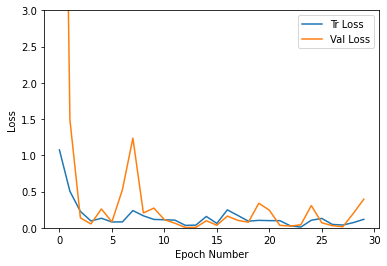

In [24]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

(0.0, 1.0)

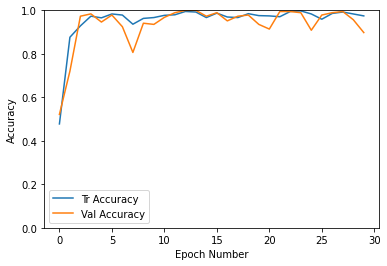

In [25]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)

In [33]:
correct_pred = {classname: 0 for classname in os.listdir(train_directory)}
total_pred = {classname: 0 for classname in os.listdir(train_directory)}

with torch.no_grad():
    for data in valid_loader:
        images, labels = data[0].to(device), data[1].to(device)
#         images = images.view(images.size(0), -1)
        outputs = gugelnet(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[os.listdir(train_directory)[label]] += 1
            total_pred[os.listdir(train_directory)[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: durian is 100.0 %
Accuracy for class: pumpkin is 97.4 %
Accuracy for class: tomato is 90.2 %
Accuracy for class: watermelon is 96.7 %


<AxesSubplot:>

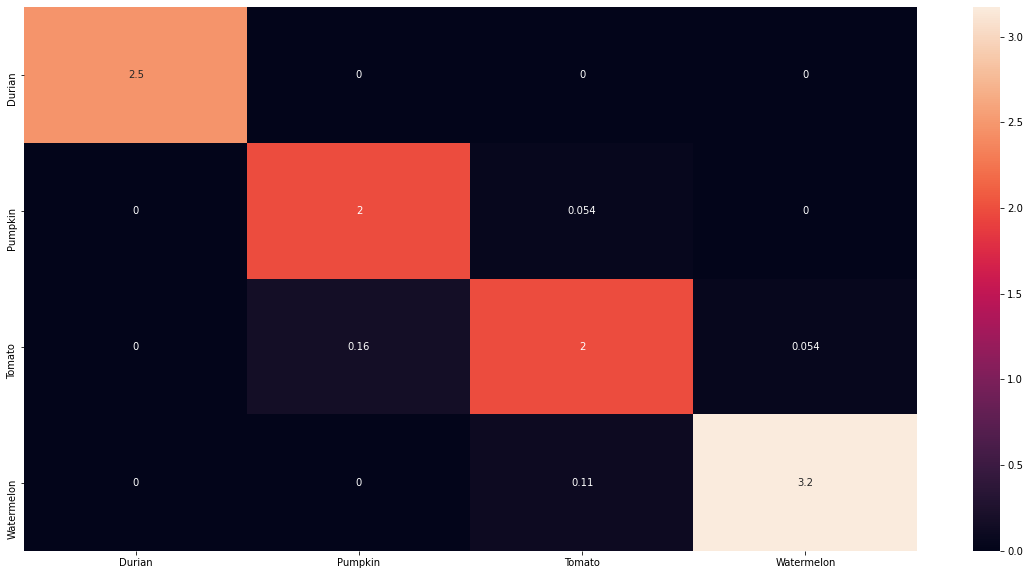

In [34]:
y_pred = []
y_true = []

gugelnet.to('cpu')

# iterate over test data
for inputs, labels in valid_loader:
        output = gugelnet(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Durian', 'Pumpkin', 'Tomato', 'Watermelon')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')

In [16]:
save_path = r'C:/Users/User/Deep Learning Workshop/test2/GoogleNet_Fruit_Classification.pt'
torch.save(gugelnet.state_dict(), save_path)
#load
# model = Net()
# model.load_state_dict(torch.load(PATH))
# model.eval())

In [17]:
save_path2 = r'C:/Users/User/Deep Learning Workshop/test2/GoogleNet_Fruit_Classification_.pt'

# Save
torch.save(gugelnet, save_path2)

# Load
# model = torch.load(save_path2)
# model.eval()

In [15]:
summary(gugelnet)

Layer (type:depth-idx)                   Param #
├─BasicConv2d: 1-1                       --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
├─MaxPool2d: 1-2                         --
├─BasicConv2d: 1-3                       --
|    └─Conv2d: 2-3                       (4,096)
|    └─BatchNorm2d: 2-4                  128
├─BasicConv2d: 1-4                       --
|    └─Conv2d: 2-5                       110,592
|    └─BatchNorm2d: 2-6                  (384)
├─MaxPool2d: 1-5                         --
├─Inception: 1-6                         --
|    └─BasicConv2d: 2-7                  --
|    |    └─Conv2d: 3-1                  12,288
|    |    └─BatchNorm2d: 3-2             (128)
|    └─Sequential: 2-8                   --
|    |    └─BasicConv2d: 3-3             18,624
|    |    └─BasicConv2d: 3-4             (110,848)
|    └─Sequential: 2-9                   --
|    |    └─BasicConv2d: 3-5             (3,104)
|    |    └─BasicConv2d: 3-6  

Layer (type:depth-idx)                   Param #
├─BasicConv2d: 1-1                       --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
├─MaxPool2d: 1-2                         --
├─BasicConv2d: 1-3                       --
|    └─Conv2d: 2-3                       (4,096)
|    └─BatchNorm2d: 2-4                  128
├─BasicConv2d: 1-4                       --
|    └─Conv2d: 2-5                       110,592
|    └─BatchNorm2d: 2-6                  (384)
├─MaxPool2d: 1-5                         --
├─Inception: 1-6                         --
|    └─BasicConv2d: 2-7                  --
|    |    └─Conv2d: 3-1                  12,288
|    |    └─BatchNorm2d: 3-2             (128)
|    └─Sequential: 2-8                   --
|    |    └─BasicConv2d: 3-3             18,624
|    |    └─BasicConv2d: 3-4             (110,848)
|    └─Sequential: 2-9                   --
|    |    └─BasicConv2d: 3-5             (3,104)
|    |    └─BasicConv2d: 3-6  